   # これはweek5のテキストです。
   ## 前半の予測モデルを作るところまではweek3のテキストと全く一緒です。


今回は東京中古マンションのデータを利用します。「housing_tokyo_chuo_line_week3.csv」のデータが与えられているとして、まずはTableauで可視化をしてみましょう。
___

**§ワーク１：　マンションの価格に強く影響を与えている説明変数（特徴量）は何ですか？**  
___



In [4]:
%%HTML
<div class='tableauPlaceholder' id='viz1579748707019' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;To&#47;TokyoChuoLineHousingPrice&#47;TokyoChuoLineHouingPrice&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TokyoChuoLineHousingPrice&#47;TokyoChuoLineHouingPrice' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;To&#47;TokyoChuoLineHousingPrice&#47;TokyoChuoLineHouingPrice&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1579748707019');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.5)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### scikit-learnで重回帰分析の実装
#### scikit-learnとは

scikit-learnとは、非常に便利なPythonの機械学習パッケージとなります。少ない行数、わかりやすいコードで機械学習を実装することができるため多くのユーザーに支持されています。Pythonの機械学習パッケージでは、デファクトスタンダードとなっております。

#### データの準備
pandasのところでも扱った、東京中古マンションのデータを読み込みましょう。

In [5]:
#pandasをインポートします。

import pandas as pd

In [6]:
#ファイルがあるか確認しましょう。
#ls 

In [7]:
# データをインポートします。
data = pd.read_csv("housing_tokyo_chuo_line_week3.csv")

In [8]:
data.head()

,uid,years,minutes,sqrm,distance,renovate,express,price
0,13101-1,34,3,35,2.983801,0,0,24000000
1,13101-2,37,4,20,2.983801,0,0,13000000
2,13101-4,34,3,30,2.983801,0,0,22000000
3,13101-5,35,1,70,2.983801,0,0,69000000
4,13101-6,34,3,25,2.983801,0,0,21000000


In [9]:
## uidは予測に必要がないので削除しましょう。
df = data.iloc[:,1:]
df.head()
## df = data.drop(['uid'],axis=1) #これでも行ける

,years,minutes,sqrm,distance,renovate,express,price
0,34,3,35,2.983801,0,0,24000000
1,37,4,20,2.983801,0,0,13000000
2,34,3,30,2.983801,0,0,22000000
3,35,1,70,2.983801,0,0,69000000
4,34,3,25,2.983801,0,0,21000000


In [10]:
# 相関行列を書いてみよう　
#おまじない
#!pip install seaborn
#!pip install matplotlib


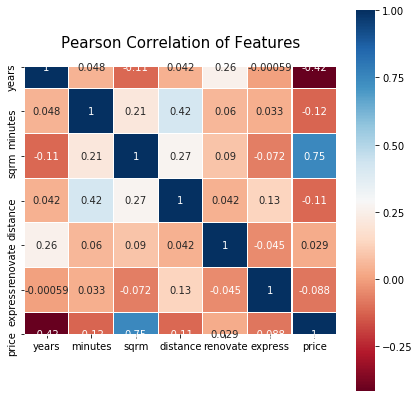

In [11]:
# 相関行列を書いてみよう　→　ここはこのまま実行しましょう！
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

colormap = plt.cm.RdBu
plt.figure(figsize=(7,7))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

___

**§ワーク2：　相関行列を見て、マンションの価格に強く影響を与えている説明変数（特徴量）は何だと思いますか？Tableau による散布図と比べてどんなことがわかりますか？　ディスカッションしてみてください。**  
___

## 予測モデルを作る

教師アリ学習での予測モデル作成の流れは以下のようになります。
![教師アリ](images/教師アリ学習.png)

予測モデルを作るために初めにすることは、「説明変数 x」と「目的変数 t」を分けることです。
まずは、入力変数`x`と出力変数`t`に分けておきましょう。分割には`iloc[]`を用います。

In [12]:
#データフレーム df には何が入っているか確認します。　→　何が目的変数ですか？

df.head()

,years,minutes,sqrm,distance,renovate,express,price
0,34,3,35,2.983801,0,0,24000000
1,37,4,20,2.983801,0,0,13000000
2,34,3,30,2.983801,0,0,22000000
3,35,1,70,2.983801,0,0,69000000
4,34,3,25,2.983801,0,0,21000000


In [13]:
#priceは除く
x = df.iloc[:, :-1] 

#priceだけ保持する
t = df.iloc[:, -1] 

#### scikit-learnのimport
データの準備ができたのでscikit-learnをimportしましょう。scikit-learnは`sklearn`という名前でimportしますが、今回は`sklearn`の中の`linear_model`（線形モデル）の中の`LinearRegression`（線形回帰）をimportします。つまり、重回帰分析を実装するための機能をピンポイントでimportするイメージです。

In [14]:
# Linear Regression の　インポート
from sklearn.linear_model import LinearRegression

#### モデルの宣言

まずは、モデル（手法）の宣言を行います。先程importした`LinearRegression()`を`model`という変数に代入してあげます。厳密には「クラスのインスタンス化」というものにあたりますが、気になる方は調べてみてください。

In [15]:
# ①モデルの宣言
model = LinearRegression()

#### モデルの学習

モデルの宣言後、**モデルの学習**を行います。モデルの学習とは、手持ちのデータを用いて適切なパラーメータを求めることです。

In [16]:
# ②モデルの学習
model.fit(x, t)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### モデルの評価

学習後のモデルを評価しましょう。モデルの評価には決定係数という指標を用います。  決定係数とは、モデルの当てはまりの良さを0から1までの値で表す指標になります。 1に近い方がより良いモデルを表しています。`score()`で評価することができます。評価するには、データも一緒に渡す必要があるため()内に、`x`と`t`を入れております。

In [17]:
# モデルの評価
model.score(x, t)

0.7928091871992431

0.79　という数値が出てきました。最大が1であることを考えると悪くはない数字かと思います。

> 補足：回帰と分類によって、`score()`を使用したときの評価指標が異なります。 分類は正解率（Accuracy）が評価指標になります。
> - 回帰：決定係数  
> - 分類：正解率（Accuracy）

決定係数とは？？



In [18]:
#③予測値をゲットしてみましょう。
p = model.predict(x)

#データフレームに変換します。
p = pd.DataFrame(p,columns=['predict'])

In [19]:
#オリジナルのデータと連結します。
results = pd.concat([data,p],axis=1)
results

,uid,years,minutes,sqrm,distance,renovate,express,price,predict
0,13101-1,34,3,35,2.983801,0,0,24000000,3.111981e+07
1,13101-2,37,4,20,2.983801,0,0,13000000,1.690843e+07
2,13101-4,34,3,30,2.983801,0,0,22000000,2.714181e+07
3,13101-5,35,1,70,2.983801,0,0,69000000,5.977734e+07
4,13101-6,34,3,25,2.983801,0,0,21000000,2.316382e+07
...,...,...,...,...,...,...,...,...,...
2994,13214-847,19,4,20,25.956039,0,1,17000000,1.109275e+07
2995,13214-848,21,1,80,25.956039,0,1,65000000,5.977867e+07
2996,13214-849,21,1,65,25.956039,0,1,42000000,4.784467e+07
2997,13214-850,15,3,25,25.956039,0,1,19000000,1.788288e+07


In [20]:
#一度CSVに落としましょう。
results.to_csv("results.LinearRegression.csv")

一度Tableauに戻って評価してみましょう。
§ワーク　実績PRICEとPREDICTの差を誤差として、東京駅からの距離（つまり駅）ごとに誤差がどのように分布するか確認してください。そして誤差が多い駅はどこかディスカッションしてみてください。

In [21]:
%%HTML
<div class='tableauPlaceholder' id='viz1579753119257' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;To&#47;TokyoChuoLineHousingPrice&#47;sheet2&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TokyoChuoLineHousingPrice&#47;sheet2' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;To&#47;TokyoChuoLineHousingPrice&#47;sheet2&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1579753119257');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [22]:
# sklearn から mean_squared_error をインポートします。
from sklearn.metrics import mean_squared_error
import math

In [23]:
#RMSEを計算します。
mse = mean_squared_error(t, p)
print('RMSE:', math.sqrt(mse))

RMSE: 9954675.510173228


RMSEとは、Root Mean Square Error（二乗平均平方根誤差）の略で、回帰モデルの最も一般的な性能指標で以下の式で表現されます。
参考　https://aizine.ai/rmse-rmsle1114/#toc1
![RMSE](images/RMSE.png)

## 訓練データと検証データに分割

みなさん、前述のモデルの評価で実はやってはいけないことをしていました。なにかわかりますでしょうか。
それは、学習に用いたデータをそのままモデルの評価に使用している点です。モデルは学習に用いたデータにうまく当てはめようと計算するのですから、うまくあてはまるのはごく自然なことですよね。
理想は学習に使用するデータにうまくあてはまるだけではなく、新しいデータに対しても上手く当てはまることを確認する必要があります。

ここで出てくるのが**訓練データ**と**検証データ**になります。手持ちのデータを2つに分割し、モデルの学習に用いる訓練データとモデルの評価に用いる検証データに分割します。このようにすることで、新しいデータへの汎用性も確かめることができます。分割の割合はだいたい7:3で行うことが多いです。理想は5:5で半分を学習に用い、半分を評価に用いることです。しかし、現実は理想通りに分割できるほどのサンプル数がありませんので、学習に用いるデータに多くの割合を割くことになります。
このようにデータを訓練データと検証データに分割することを **ホールドアウト法** と呼びます。

また、ここで抑えておきたい話の中に**過学習（オーバーフィッティング）**というものがあります。これは、訓練データにうまく当てはまりすぎてしまい、新しいデータへの汎用性を失ってしまうことを意味します。例えるならば、定期試験前に過去問をひたすら勉強し、過去問では100点をたくさん取ることができるが、実際の試験では60点くらいしか取れないようなイメージです。過去のデータに**学習**し**過**ぎてしまう現象です。

上記のことを踏まえ、実際にホールドアウト法でもう一度実装してみましょう。
`sklearn`の中の`model_selection`の中に`train_test_split`がありますので、こちらをimportしましょう。



In [24]:
from sklearn.model_selection import train_test_split

それぞれ以下の変数名で定義します。
- `x`の訓練データ：`x_train`
- `t`の訓練データ：`t_train`
- `x`の検証データ：`x_val`
- `t`の検証データ：`t_val`

`val`は`validation`（検証）の略です。検証データの割合を全体の30%（0.3）とし、ランダムに分割します。下記のコードを実行するたびに異なるランダムでデータが分割されるのを防ぐために`random_state=3`を指定します。指定する数値は何でも構いませんが、同じ数値にしておくと同じ結果になりますので、今回は3にしておくことをオススメいたします。実行するたびに分割されるデータが変わらないように**再現性の確保**を行っております。各データの`shape`も確認しておきましょう。

![holdout](images/holdout.png)

In [25]:
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=3)
print('訓練データ : ', x_train.shape, t_train.shape)
print('検証データ : ', x_val.shape, t_val.shape)

訓練データ :  (2099, 6) (2099,)
検証データ :  (900, 6) (900,)


行数を確認すると、7:3の割合で分割できていることがわかるかと思います。
それでは、先程と同様にモデルの宣言から評価までを行いましょう。

In [26]:
model = LinearRegression()

学習には訓練データを用います。

In [27]:
model.fit(x_train, t_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

過学習が起きていないことを確認するために、モデルの評価は訓練データ、検証データの両方で行います。

In [28]:
model.score(x_train, t_train)

0.7831603492195098

In [29]:
model.score(x_val, t_val)

0.8144570876578032

訓練データと検証データへの決定係数の値がほぼ同じであるため、過学習が起きていないことがわかります。
これで評価までの一連の流れはできました。最後に予測値をもとめましょう。

#### RMSEでも評価してみましょう。

In [30]:
# ここはおまじないと思って実行してください。

from sklearn.metrics import mean_squared_error
import math

In [31]:
type(x_val)

pandas.core.frame.DataFrame

In [32]:
pd.DataFrame(x_val)

,years,minutes,sqrm,distance,renovate,express
1283,10,4,35,9.492734,0,1
250,46,8,30,6.580371,1,0
2153,25,18,55,31.925628,0,1
2239,45,19,60,17.027550,1,0
632,8,4,60,5.800329,0,0
...,...,...,...,...,...,...
2926,18,2,55,29.003514,0,0
577,19,6,55,4.152266,1,0
2191,16,16,70,31.925628,1,1
424,41,3,30,2.983801,0,0


In [33]:
p_val = model.predict(x_val)
p_train = model.predict(x_train)

In [34]:
p_val

array([ 3.95512921e+07,  1.82268293e+07,  2.15721278e+07,  2.74943981e+07,
        6.23424823e+07,  3.60096736e+07,  2.21647547e+07,  2.33770982e+07,
        5.57332463e+07,  4.04405285e+07,  3.41178031e+07,  3.76434229e+07,
        5.50073983e+07,  1.90025397e+07,  1.11099451e+07,  1.90025397e+07,
        5.20661386e+07,  3.54746965e+07,  2.54840460e+07,  3.75232378e+06,
        5.26444824e+07,  5.84473099e+07,  4.18204625e+07,  3.92464676e+07,
        5.15191059e+07,  4.46725865e+07,  3.16095885e+07,  3.91360108e+07,
        8.37623354e+06,  4.64578688e+07,  5.81505077e+07,  4.43537545e+07,
       -2.87375724e+06,  1.54237171e+07,  5.20465767e+07,  1.08671083e+07,
       -5.50525486e+06,  5.29245172e+07,  9.02070860e+07,  5.55194942e+07,
        6.39208241e+07,  5.40258723e+07,  5.02468328e+07,  5.55120817e+06,
        2.89750752e+07,  4.80984056e+07,  3.18043571e+07,  1.55326592e+07,
        1.49576646e+07,  5.97054827e+07,  3.98551374e+07,  9.16973442e+06,
        5.21390235e+07,  

In [35]:
#評価は検証データで行います。
mse = mean_squared_error(t_val, p_val)
print('RMSE:', math.sqrt(mse))

RMSE: 9362636.306389766


In [36]:
#訓練データについてはおまけです。
mse = mean_squared_error(t_train, p_train)
print('RMSE:', math.sqrt(mse))

RMSE: 10205189.819081264


# week3はここまでででした・・・
簡単に終わってしまう方はweek3のおまけで紹介したXGBoostなど他のモデルも使ってみましょう。

# week5はここからです！
### STEP1. 国土交通省の中古マンション取引履歴から頑張ってデータ準備した訓練データで予測モデルを作成しました。
### STEP2. 教師データに含まれているはずもない、Web上の不動産物件情報に対して、価格の予測を行い、実際と比較してみましょう。
#### お買い得物件が見つかるかもしれません。

In [37]:
#jupyter notebook が開いているところにあるファイルを確認
!dir #windows
!ls #mac

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は 2CB0-A238 です

 C:\Users\USER\Documents\iwahashi\iwahashi\splineglobal\TableauDS学習塾\long2\week5\week5-contents のディレクトリ



ファイルが見つかりません
'ls' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


HOMES（不動産仲介業）のウェブサイト（　https://www.homes.co.jp/mansion/chuko/　）からスクレイピングし、
機械学習のモデルに投入できるように、諸々前準備したファイルをを利用します。（"HOMES_SCRAPING_ChuoLine_lat_long-UTF8.csv"）
このファイルはHOMESのWEBに今（2020-02-08)掲載されている、物件の条件や画像リンク、緯度経度が含まれています。

※　今回は　Google ChromeプラグインのInstant Data Sraper（https://chrome.google.com/webstore/detail/instant-data-scraper/ofaokhiedipichpaobibbnahnkdoiiah） を利用してある程度スクレイピングしたものをTableau Prep Builderで加工しました。


In [38]:
# データをインポートします。
data_scraping = pd.read_csv("HOMES_SCRAPING_ChuoLine_lat_long-UTF8.csv")

In [39]:
#中身を確認します。
data_scraping.head()

,id,bukkenName,years,minutes,sqrm,distance,renovate,express,price,rooms,...,displayPic -https,raSpecRow,relatedKeywordsData,relatedKeywordsData 2,relatedKeywordsData 3,relatedKeywordsData 4,textFeatureComment,relatedKeywordsData 5,緯度,経度
0,1,九段フラワーホーム,41,5,42.14,2.960148,1,0,4480,1LDK,...,https://image.homes.jp/smallimg/image.php?file...,11,駐車場あり,エレベーター,最上階,スーパー800m以内,当社売主。いつでも内覧可能です。市ヶ谷駅より徒歩5分、4路線利用可能の大規模マンション。,NaN,35.693810,139.739639
1,2,曙マンション,47,12,47.99,31.925628,1,1,1690,2DK,...,https://image2.homes.jp/smallimg/image.php?fil...,29,リノベーション・リフォーム,エレベーター,NaN,NaN,4階部分南西向きにつき陽当り良好／ＪＲ中央線「立川」駅徒歩12分,NaN,35.702904,139.424179
2,3,東中野ＲＨソサエテイ,48,3,43.60,7.768448,1,0,2980,1LDK,...,https://image.homes.jp/smallimg/image.php?file...,30,リノベーション・リフォーム,駐車場あり,エレベーター,スーパー800m以内,東中野駅徒歩3分の好立地／8階角部屋につき眺望良好です,角部屋,35.707783,139.686844
3,4,小金井スカイコーポラス,51,6,61.05,23.604636,1,0,2180,1SLDK,...,https://image2.homes.jp/smallimg/image.php?fil...,30,リノベーション・リフォーム,ペット相談可,駐車場あり,エレベーター,土地権利：所有権のお部屋／武蔵小金井駅徒歩6分の大規模マンションです／ペット飼育相談,スーパー800m以内,35.697376,139.505692
4,5,境南マンション,51,9,47.38,20.154785,1,0,1980,2LDK,...,https://image.homes.jp/smallimg/image.php?file...,30,リノベーション・リフォーム,オートロック,エレベーター,角部屋,JR中央線「武蔵境」駅徒歩9分／南向き角部屋で眺望・陽当たり良好,NaN,35.699955,139.536057


In [40]:
#予測に必要な特徴量（説明変数はilocの列指定で、 2:8 です。）
test_x = data_scraping.iloc[:,2:8]

In [41]:
#中身を確認します。
test_x.head()

,years,minutes,sqrm,distance,renovate,express
0,41,5,42.14,2.960148,1,0
1,47,12,47.99,31.925628,1,1
2,48,3,43.60,7.768448,1,0
3,51,6,61.05,23.604636,1,0
4,51,9,47.38,20.154785,1,0


In [42]:
# predict_price に予測結果を格納します。
predict_price = model.predict(test_x)

In [43]:
# 予測結果をDataFrame型に変換します。
df_predict_price = pd.DataFrame(predict_price, columns=['predict'])

In [44]:
#元々の情報に予測結果を追加します。concatを使います。
scraping_predict =  pd.concat([data_scraping,df_predict_price],axis=1)

In [45]:
scraping_predict.head()

,id,bukkenName,years,minutes,sqrm,distance,renovate,express,price,rooms,...,raSpecRow,relatedKeywordsData,relatedKeywordsData 2,relatedKeywordsData 3,relatedKeywordsData 4,textFeatureComment,relatedKeywordsData 5,緯度,経度,predict
0,1,九段フラワーホーム,41,5,42.14,2.960148,1,0,4480,1LDK,...,11,駐車場あり,エレベーター,最上階,スーパー800m以内,当社売主。いつでも内覧可能です。市ヶ谷駅より徒歩5分、4路線利用可能の大規模マンション。,NaN,35.693810,139.739639,3.521652e+07
1,2,曙マンション,47,12,47.99,31.925628,1,1,1690,2DK,...,29,リノベーション・リフォーム,エレベーター,NaN,NaN,4階部分南西向きにつき陽当り良好／ＪＲ中央線「立川」駅徒歩12分,NaN,35.702904,139.424179,1.187765e+07
2,3,東中野ＲＨソサエテイ,48,3,43.60,7.768448,1,0,2980,1LDK,...,30,リノベーション・リフォーム,駐車場あり,エレベーター,スーパー800m以内,東中野駅徒歩3分の好立地／8階角部屋につき眺望良好です,角部屋,35.707783,139.686844,3.051689e+07
3,4,小金井スカイコーポラス,51,6,61.05,23.604636,1,0,2180,1SLDK,...,30,リノベーション・リフォーム,ペット相談可,駐車場あり,エレベーター,土地権利：所有権のお部屋／武蔵小金井駅徒歩6分の大規模マンションです／ペット飼育相談,スーパー800m以内,35.697376,139.505692,2.937443e+07
4,5,境南マンション,51,9,47.38,20.154785,1,0,1980,2LDK,...,30,リノベーション・リフォーム,オートロック,エレベーター,角部屋,JR中央線「武蔵境」駅徒歩9分／南向き角部屋で眺望・陽当たり良好,NaN,35.699955,139.536057,1.892513e+07


In [46]:
#csvに吐き出します。
scraping_predict.to_csv("Chuoline_Scraiping+Predict.csv")

Tableau Desktop から予測値を含む　"Chuoline_Scraiping+Predict.csv"　に接続し、予測値を使ったダッシュボードを作ってみましょう。
もし、不動産業の担当であれば、物件の条件から相場を予測することに利用できるかもしれません。
今回は既に価格のわかっているデータではありますから、相場（予測）と実際の差分から、「お買い得物件」を発見できるかもしれません。


このデータをもとにワークブックを作成し、Tableau Public に掲載したサンプルです。

In [47]:
%%HTML
<div class='tableauPlaceholder' id='viz1581142085782' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;KD&#47;KD7QTP8FH&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;KD7QTP8FH' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;KD&#47;KD7QTP8FH&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1581142085782');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.minHeight='1400px';vizElement.style.maxHeight=(divElement.offsetWidth*1.77)+'px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### 補足　GBDT (Gradient Boost Decision Tree）を試してみましょう。

In [48]:
!pip install xgboost

In [49]:
import xgboost as xgb
from sklearn.metrics import log_loss

In [50]:
#GBDTで扱える形に変更
dtrain = xgb.DMatrix(x_train, label=t_train)
dvalid = xgb.DMatrix(x_val, label=t_val)

In [51]:
params = {'objective':'reg:squarederror', 'silent':1 , 'random_state':71}
num_round =50

In [52]:
watchlist = [(dtrain,'train'),(dvalid,'eval')]

In [53]:
model = xgb.train(params, dtrain,num_round, evals=watchlist)

[0]	train-rmse:29345464.00000	eval-rmse:30107838.00000
[1]	train-rmse:21457544.00000	eval-rmse:22077260.00000
[2]	train-rmse:16003146.00000	eval-rmse:16502447.00000
[3]	train-rmse:12248599.00000	eval-rmse:12898969.00000
[4]	train-rmse:9725397.00000	eval-rmse:10586329.00000
[5]	train-rmse:8051797.00000	eval-rmse:9131700.00000
[6]	train-rmse:6949698.50000	eval-rmse:8131266.50000
[7]	train-rmse:6226293.00000	eval-rmse:7609303.00000
[8]	train-rmse:5746667.50000	eval-rmse:7268201.00000
[9]	train-rmse:5450014.00000	eval-rmse:7097845.50000
[10]	train-rmse:5195719.00000	eval-rmse:7010491.50000
[11]	train-rmse:4999173.00000	eval-rmse:6976026.50000
[12]	train-rmse:4857461.00000	eval-rmse:6952394.00000
[13]	train-rmse:4745307.50000	eval-rmse:6903715.50000
[14]	train-rmse:4646628.50000	eval-rmse:6885524.50000
[15]	train-rmse:4599365.00000	eval-rmse:6884738.00000
[16]	train-rmse:4517039.00000	eval-rmse:6839118.00000
[17]	train-rmse:4482251.00000	eval-rmse:6808832.00000
[18]	train-rmse:4442178.50000

In [55]:
#予測値をゲットします。
va_pred = model.predict(dvalid)
train_pred = model.predict(dtrain)

In [56]:
from sklearn.metrics import mean_squared_error
import math

In [57]:
# 検証データについてRMSEを確認します。
mse = mean_squared_error(t_val, va_pred)
print('RMSE:', math.sqrt(mse))

RMSE: 6759427.434418186


In [59]:
#訓練データについてRMSEを確認します。
mse = mean_squared_error(t_train, train_pred)
print('RMSE:', math.sqrt(mse))

RMSE: 3525009.745799859


####  GBDTモデルでの予測値を利用してダッシュボードを作ってみましょう。